In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
sys.path.extend(['..'])

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import make_moons
from scipy.stats import norm

from torch.nn.functional import softmax as torch_softmax

from models import DNN
from utils import plot_toy_regions, factorized_gauss_KLD, factorized_gauss_ar

In [4]:
dev = torch.device('cuda:1')

## Toy example: 2D Classification 

In [5]:
X, y = make_moons(n_samples=200, noise=0.15)

X_train = torch.as_tensor(X, dtype=torch.float32)
y_train = torch.as_tensor(y, dtype=torch.float32).view(-1, 1)

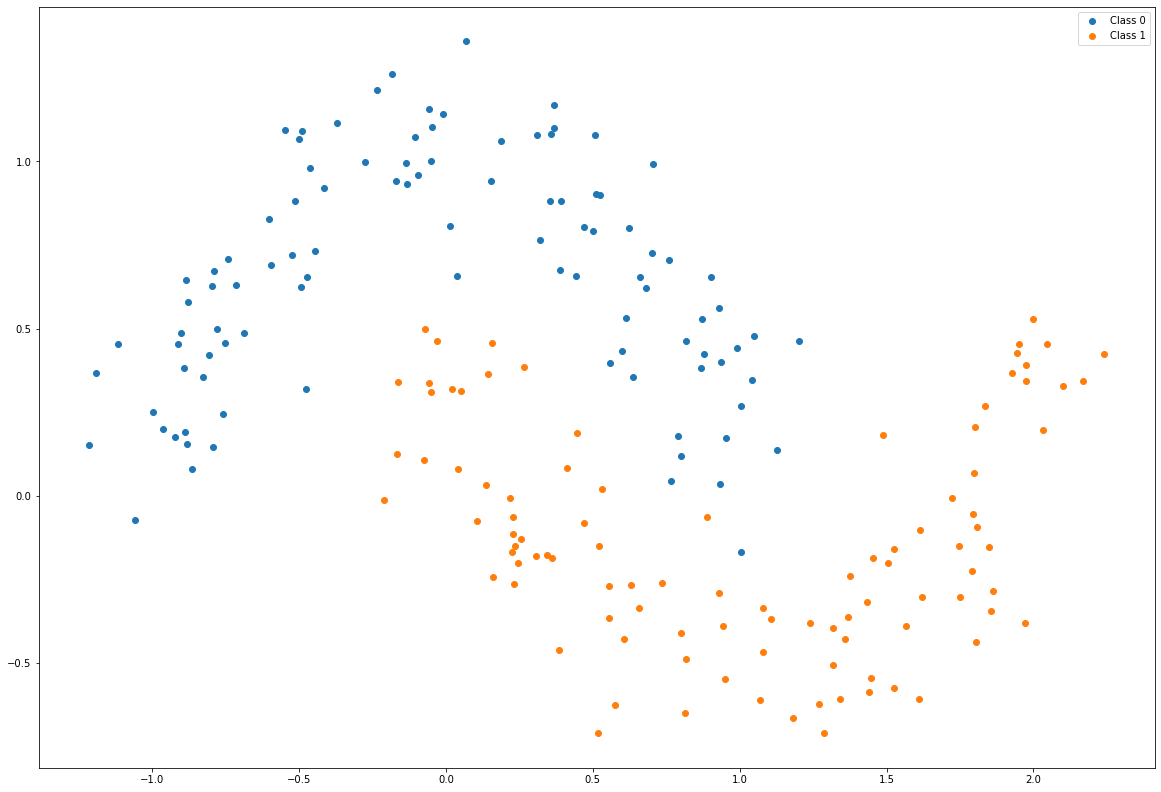

In [6]:
fig, ax = plt.subplots(figsize=(20, 14))

ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], label='Class 1')
ax.legend()

plt.show();

### DNN overfitting:

In [7]:
epochs = 5000

In [8]:
# Define forward pass
dnn = DNN(d_in=2, d_out=1, hidden_size=[10, 10])

# Initialized set of parameters
Wb = dnn.gen_params()

# Init optimizer and loss function
optimizer = torch.optim.SGD([Wb], lr=1e-3)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [9]:
_loss = []
for e in range(epochs):
    
    z = dnn(X_train, Wb)
    
    curr_loss = loss(z, y_train)
    
    curr_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    _loss.append(curr_loss.item())

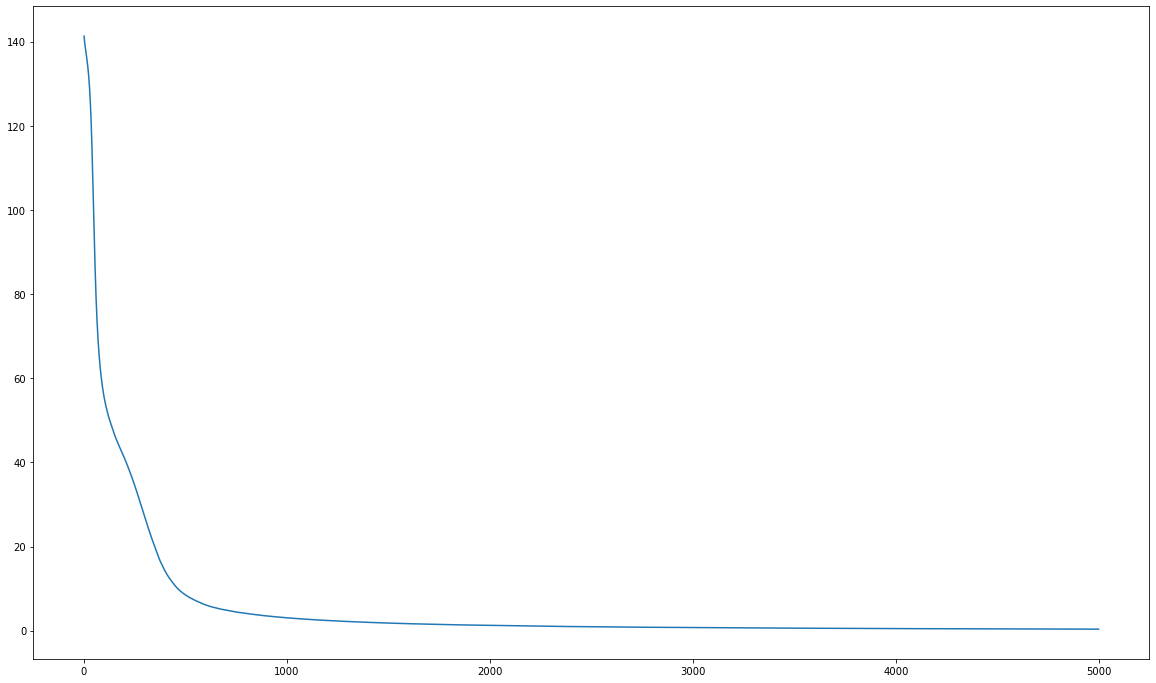

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))

ax.plot(_loss)

plt.show()

In [11]:
def predict(X, Wb):
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32, device=Wb.device)
    z = dnn(X, Wb)
    return torch.sigmoid(z).cpu().detach().numpy()

We have perfect accuracy:

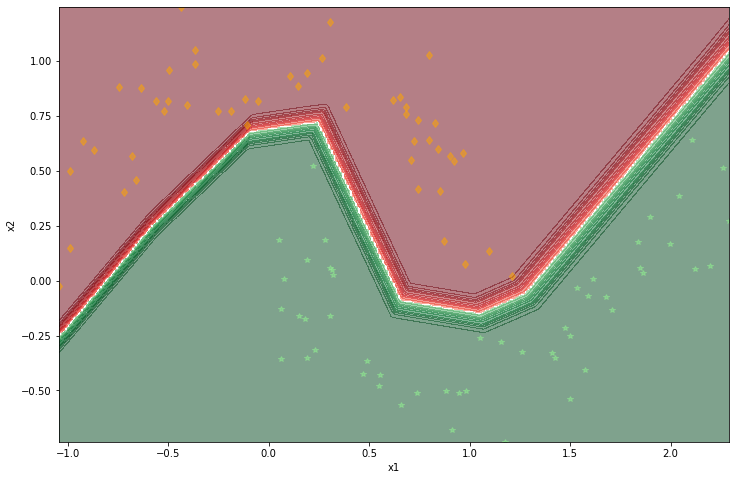

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict(x, Wb),
                      ax=ax)
plt.show();

But we make confident predictions on regions of input space where we have seen no data.

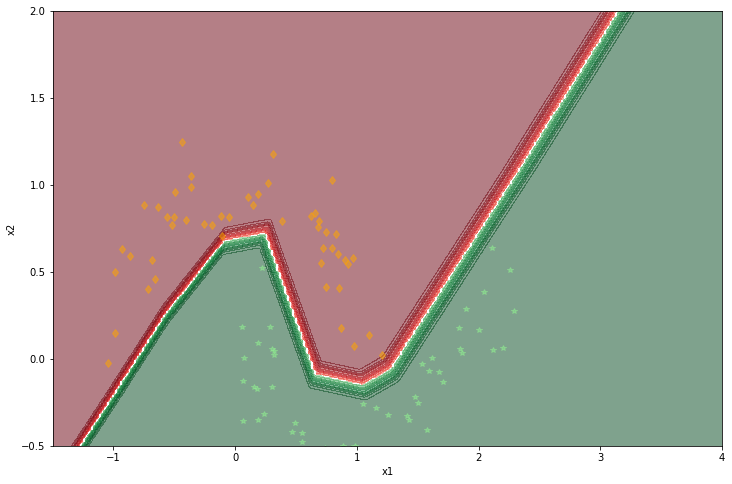

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict(x, Wb),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

### Model Average

#### One solution is to average over models that explain well the data:

In [31]:
n_models = 20

# Initialized set of parameters
Wbs = [dnn.gen_params() for _ in range(n_models)]

# Init optimizer and loss function
optimizer = torch.optim.SGD(Wbs, lr=1e-2)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [32]:
_loss = [[] for _ in range(n_models)]
for e in range(epochs):
    curr_loss = []
    for i, Wb in enumerate(Wbs):
        z = dnn(X_train, Wb)
    
        curr_loss.append(loss(z, y_train))
        
        _loss[i].append(curr_loss[-1])
    
    sum(curr_loss).backward()
    optimizer.step()
    optimizer.zero_grad()

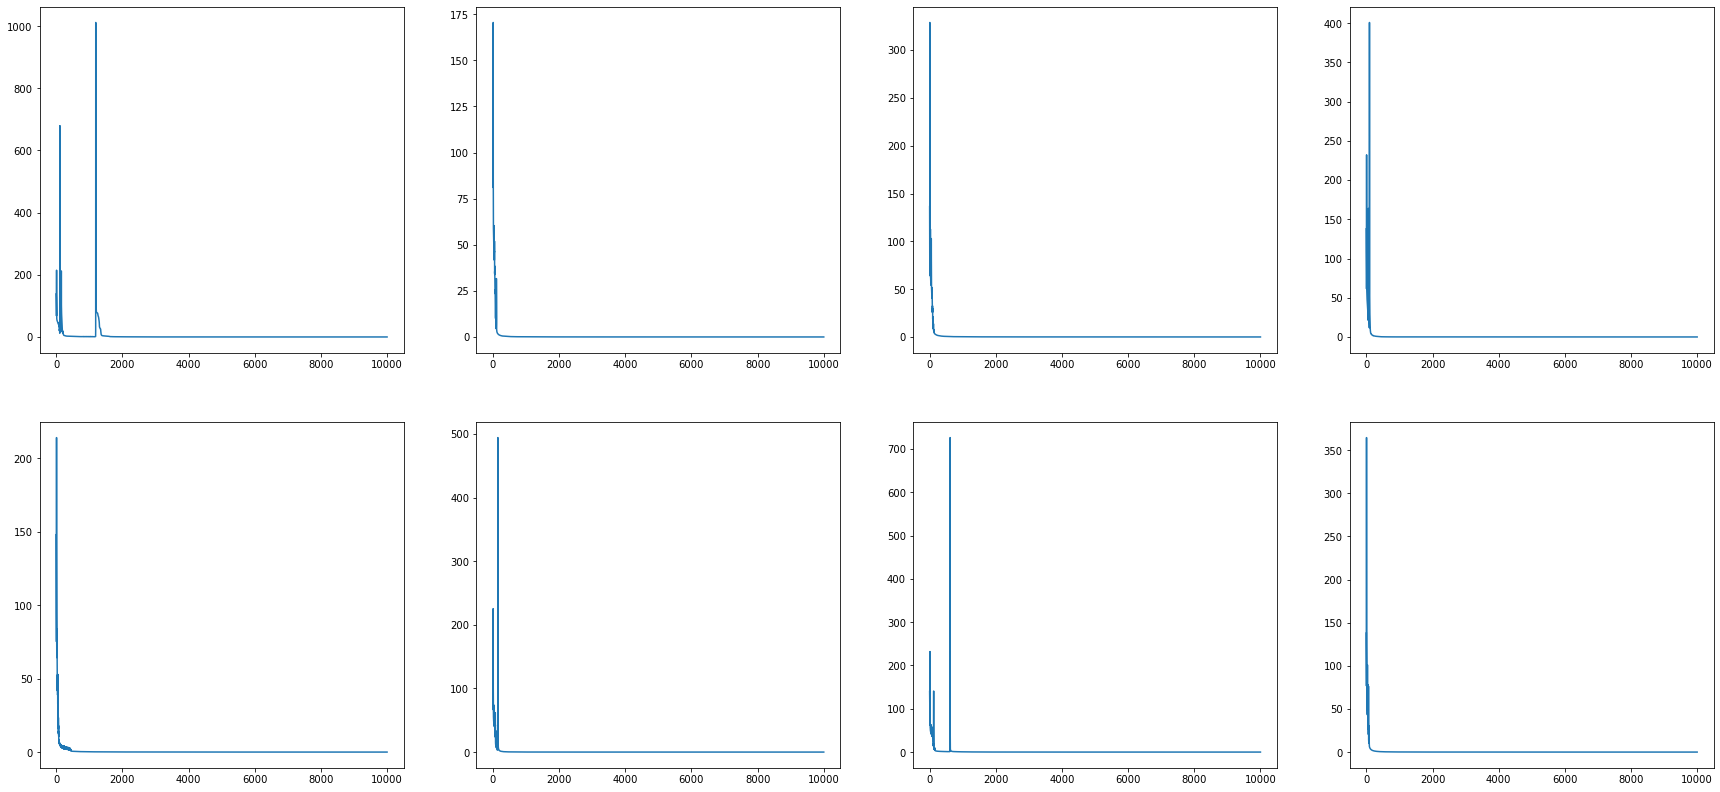

In [33]:
fig, ax = plt.subplots(2, 4, figsize=(30, 14))

for i in range(8):

    ax[i//4, i%4].plot(_loss[i])

plt.show()

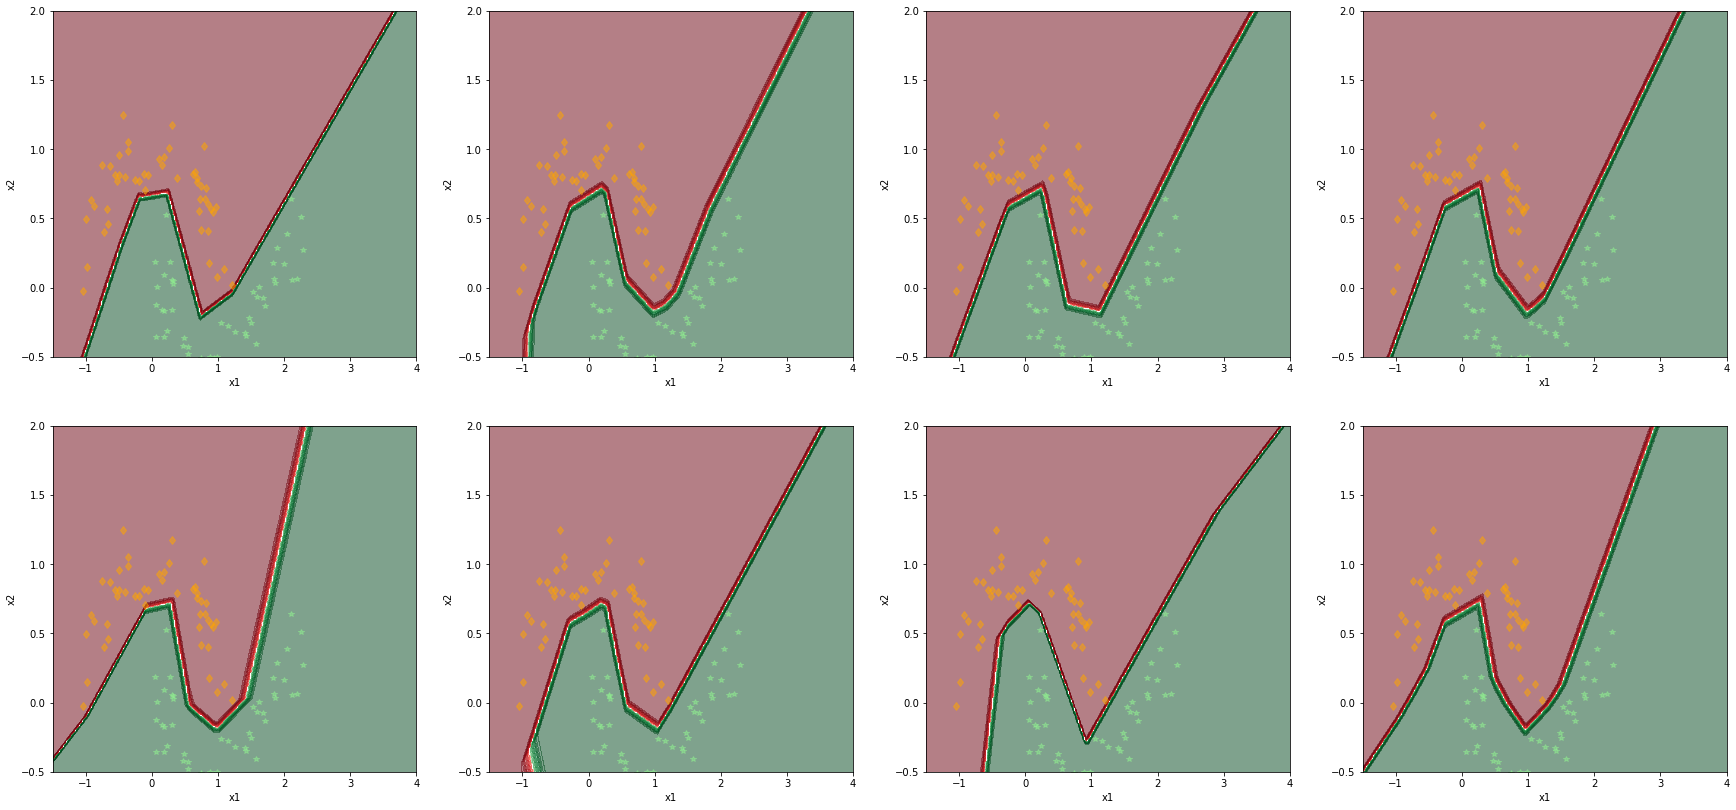

In [34]:
fig, ax = plt.subplots(2, 4, figsize=(30, 14))

for i in range(8):
    ax[i//4, i%4] = plot_toy_regions(X_train[:100], y_train[:100],
                          lambda x: predict(x, Wbs[i]),
                          ax=ax[i//4, i%4],
                          xlims=(-1.5, 4),
                          ylims=(-0.5, 2))
plt.show();

In [35]:
def predict_enseble(X, Wbs):
    preds = []
    if not torch.is_tensor(X):
        X = torch.as_tensor(X, dtype=torch.float32, device=Wbs[0].device)
    for Wb in Wbs:
        z = dnn(X, Wb)
        preds.append(torch.sigmoid(z).cpu().detach().numpy())
    
    return sum(preds)/len(preds)

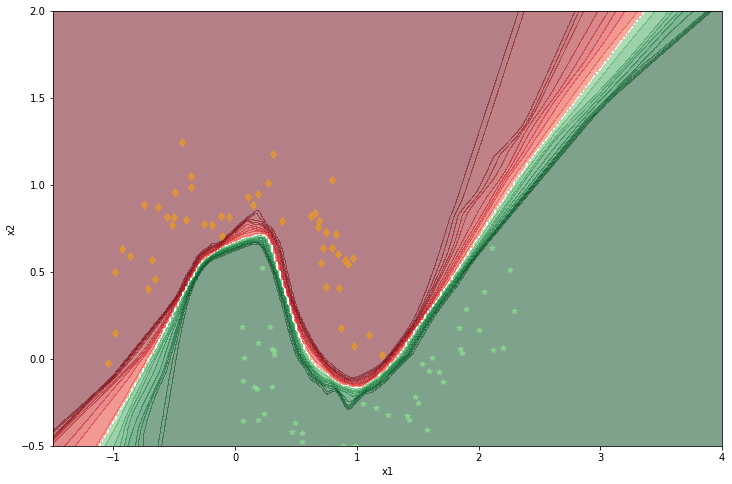

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict_enseble(x, Wbs),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

### Bayesian Model Average

Bayesian Inference allows to make predictions averagins marginalizing over the parameter space of $\theta$ the posterior distribution of $\theta$ having observed some data $\mathcal{D}$:

$$
p(y | x, \mathcal{D}) = \int p(y| x, \theta)p(\theta|\mathcal{D})d\theta
$$

However, $p(\theta|\mathcal{D})$ has no tractable solution for DNNs and we resort to approximate methods instead.

### VI

Approximate the parameters $\phi$ of a variational distribution $q_\phi(\theta)$ such that:
$$
\begin{align}
\phi^* &= \arg\min_\phi D_{KL} [q_\phi(\theta) || p(\theta|\mathcal{D})] \\
&= \arg\min_\phi D_{KL} [ q_\phi(\theta) || \frac{p(\mathcal{D} || \theta)p(\theta)}{p(\mathcal{D})} ] \\
&= \arg\min_\phi \mathbb{E}_{q_\phi(\theta)}[-\log p(\mathcal{D} || \theta)] + D_{KL} [ q_\phi(\theta) || p(\theta) ]
\end{align}
$$

#### Mean Field Gaussian

Standard Normal prior:

In [20]:
## Initialize variational parameters
mu = dnn.gen_params()
log_var = nn.Parameter(torch.randn_like(mu) - 10)

# Prior distribution
pmu = torch.tensor([0.0], requires_grad=False)
plog_var = torch.tensor([-1.0], requires_grad=False)

In [22]:
def sample_factorized_gauss(mu, log_var, n_samples):
    Z = mu.view(1, -1) + torch.randn((n_samples, mu.shape[0]), device=mu.device)*torch.sqrt(torch.exp(log_var))
    return Z

In [23]:
epochs = 10000
MC_samples = 500

optimizer = torch.optim.Adam([mu, log_var], lr=1e-3)
nll = nn.BCEWithLogitsLoss(reduction='sum')

In [24]:
_elbo = []
_nlls = []
_KL = []

t0 = time.time()
for e in range(epochs):
    
    Wbs = sample_factorized_gauss(mu, log_var, MC_samples)
    
    _nll = 0.0
    
    for Wb in Wbs:
    
        z = dnn(X_train, Wb)
    
        _nll += nll(z, y_train)
        
    _nll /= MC_samples
    
    KL = factorized_gauss_KLD(mu, log_var, pmu, plog_var)
    nelbo = _nll + 0.001*KL
    
    nelbo.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    _elbo.append(-nelbo.item())
    _nlls.append(_nll.item())
    _KL.append(KL.item())
    
    if e%10==0:
        print("Training: {:.3f}% completed at time {:.2f}s".format(100*(e/epochs), time.time()-t0), end="\r")

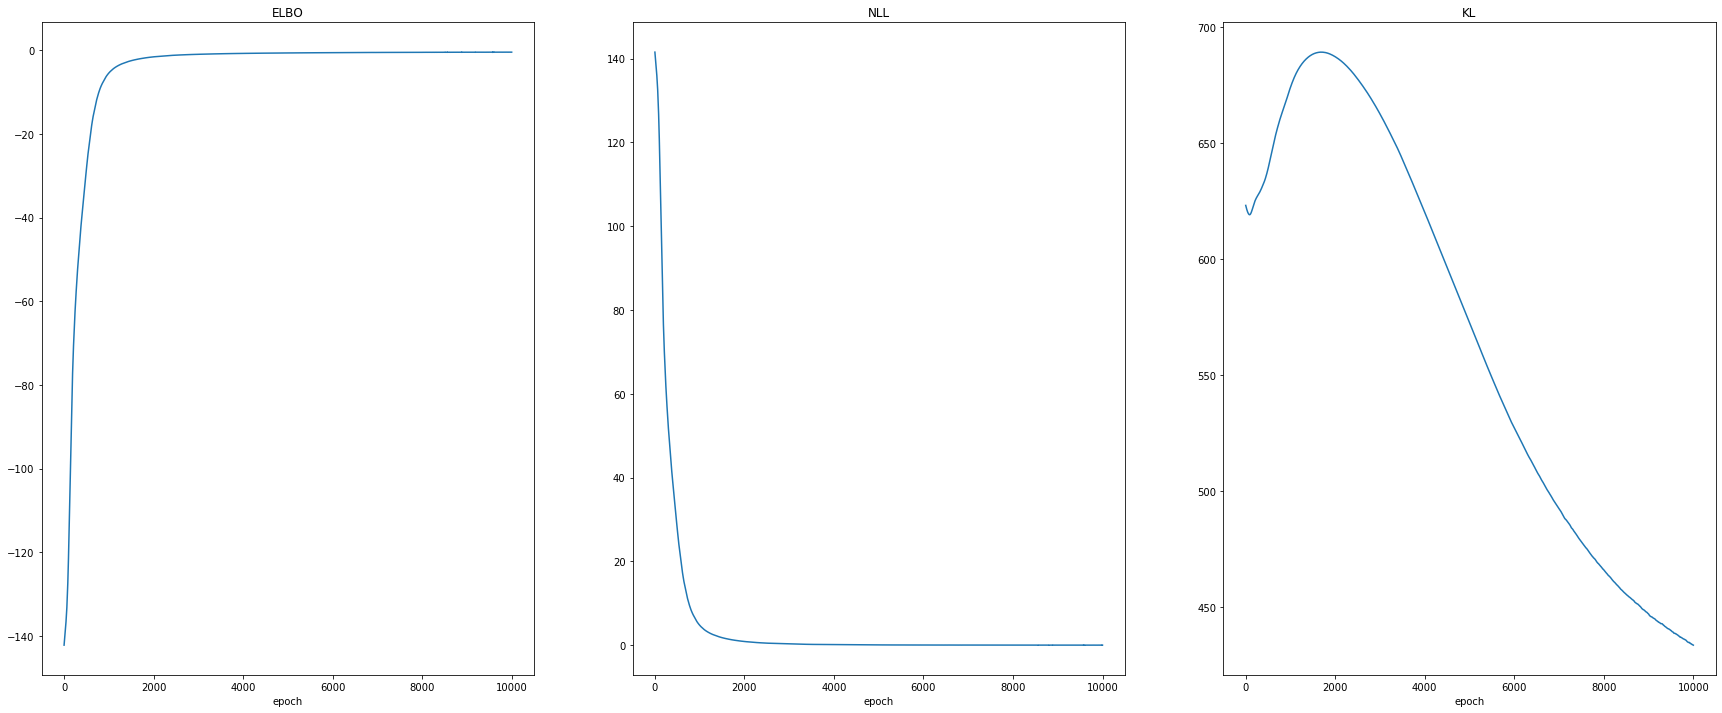

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(30, 12))

ax[0].plot(_elbo)
ax[0].set_title('ELBO')
ax[0].set_xlabel('epoch')

ax[1].plot(_nlls)
ax[1].set_title('NLL')
ax[1].set_xlabel('epoch')

ax[2].plot(_KL)
ax[2].set_title('KL')
ax[2].set_xlabel('epoch')


plt.show()

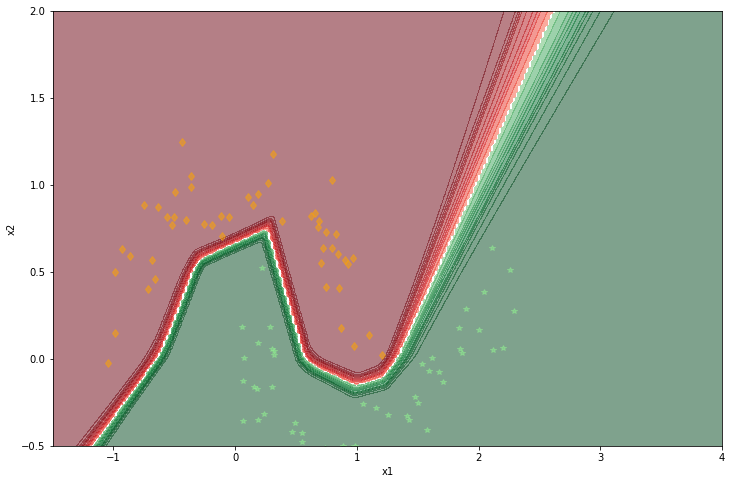

In [26]:
Wbs = sample_factorized_gauss(mu, log_var, 100)

fig, ax = plt.subplots(figsize=(12, 8))


ax = plot_toy_regions(X_train[:100], y_train[:100],
                      lambda x: predict_enseble(x, Wbs),
                      ax=ax,
                      xlims=(-1.5, 4),
                      ylims=(-0.5, 2))
plt.show();

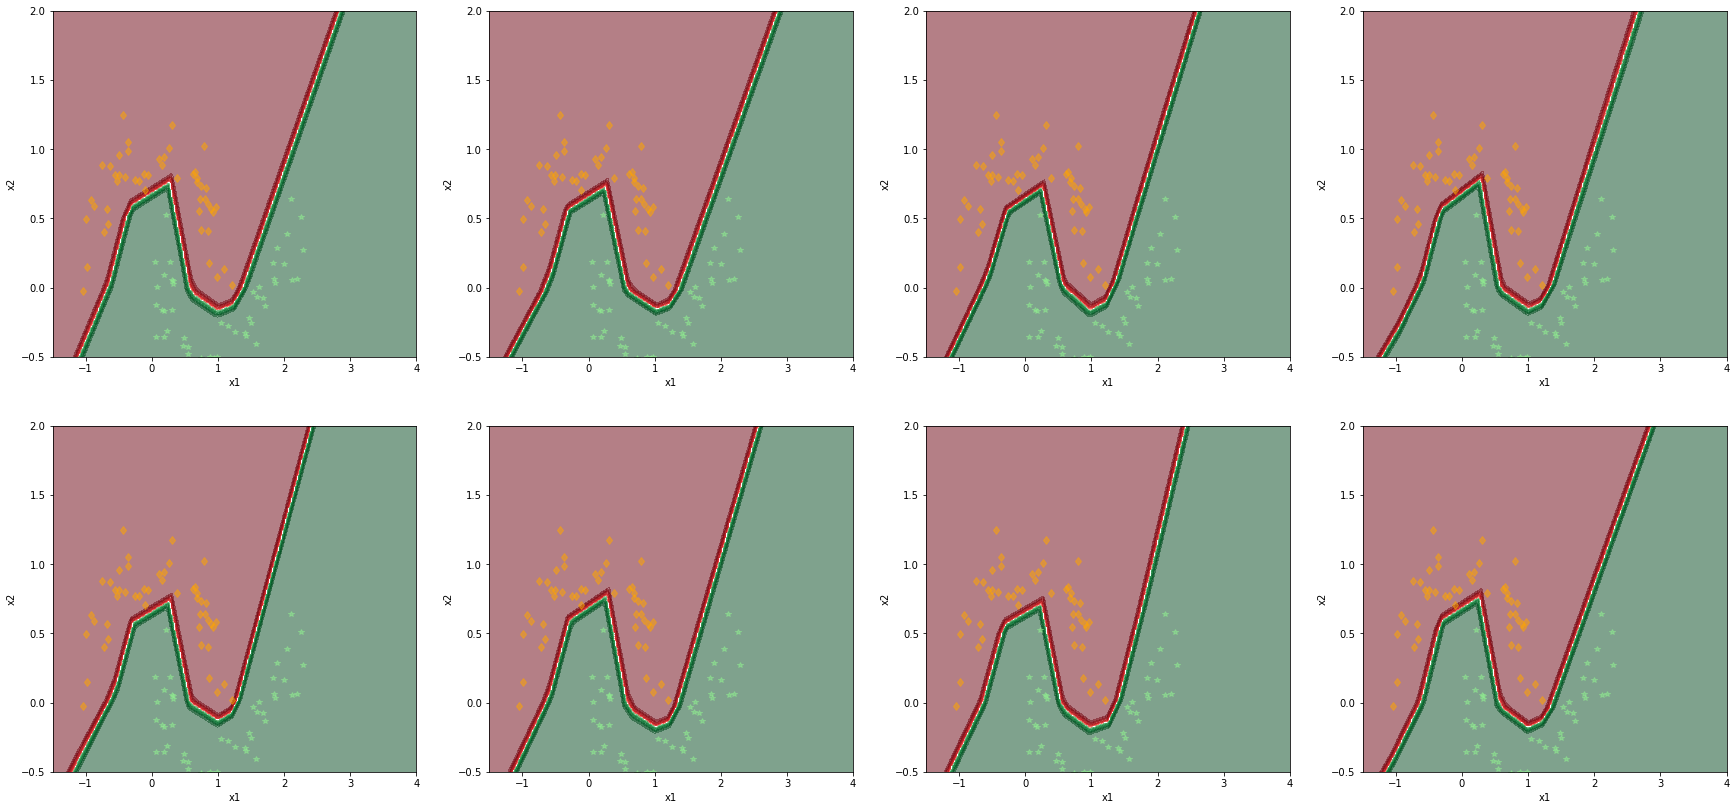

In [28]:
Wbs = sample_factorized_gauss(mu, log_var, 8)


fig, ax = plt.subplots(2, 4, figsize=(30, 14))

for i in range(8):
    ax[i//4, i%4] = plot_toy_regions(X_train[:100], y_train[:100],
                          lambda x: predict(x, Wbs[i]),
                          ax=ax[i//4, i%4],
                          xlims=(-1.5, 4),
                          ylims=(-0.5, 2))
plt.show();

In [29]:
mu

Parameter containing:
tensor([ 1.8604,  1.3947,  0.0157,  1.8897,  1.5813, -1.8315,  0.5827,  1.2322,
        -2.6284, -2.1767,  1.3636, -0.4767, -1.8815,  0.8336, -1.3458,  0.2738,
         0.8867,  1.6048,  1.7110,  1.5746, -0.2518, -1.4673, -0.0104, -2.2016,
        -0.8742,  1.8412, -0.3166,  0.6119, -0.5916, -0.6013,  0.6420,  1.8691,
        -1.0306, -0.7336, -1.2810,  0.9550,  1.0470, -0.9084,  1.4049,  0.9537,
         1.3727, -1.3053,  0.8392,  0.6331,  0.7129, -0.4579, -0.4505,  0.5010,
        -0.8024, -0.5772,  1.2933, -1.2797,  0.6426,  0.7142,  0.5527, -0.3410,
        -0.3351,  0.6306, -0.6567, -0.5046,  2.0719, -1.7363,  1.0956,  0.8400,
         0.9879, -0.6564, -0.6819,  0.9177, -1.1926, -1.0249,  1.8344, -1.7474,
         0.8040,  0.5425,  0.6784, -0.4007, -0.4684,  0.5666, -0.7942, -0.5913,
        -0.5660, -2.0141,  0.9450,  0.6175,  1.0187, -0.2696, -0.2826,  0.8049,
        -0.5214, -0.5132,  0.1650,  0.9675, -0.0104,  0.0352,  0.0097,  0.4068,
         0.4013, -

In [30]:
log_var

Parameter containing:
tensor([-8.1157, -7.8972, -7.4600, -8.2496, -8.2434, -6.4735, -5.9830, -4.2746,
        -6.1438, -5.7755, -7.8658, -4.1232, -3.4295, -4.4132, -4.6234, -7.0727,
        -5.4117, -4.5085, -7.6345, -7.2986, -9.2047, -7.5091, -7.2239, -7.5970,
        -7.8984, -8.2962, -6.8035, -6.0146, -8.7311, -8.3850, -5.8380, -5.9761,
        -4.8871, -4.3419, -4.5093, -3.5263, -3.7439, -4.1239, -5.0737, -4.3619,
        -2.5703, -2.6666, -1.9248, -1.6429, -1.5638, -1.3299, -1.3787, -1.8058,
        -1.9111, -1.8929, -2.1375, -2.1292, -1.5556, -1.3663, -1.4452, -1.1821,
        -1.7042, -1.6583, -1.6573, -1.3663, -3.2381, -3.1453, -2.2883, -2.0999,
        -1.6482, -1.7624, -1.6353, -1.7100, -2.7092, -1.9611, -4.6749, -4.5634,
        -3.5569, -3.0705, -3.2137, -2.3300, -2.5831, -2.8248, -3.7116, -3.0816,
        -3.1642, -6.6593, -6.0311, -5.4815, -5.8396, -4.5680, -4.7661, -5.2241,
        -6.1686, -5.3921, -3.5574, -3.8170, -2.8139, -2.3138, -2.8100, -1.8040,
        -1.9555, -

## Effect of robust divergences

$$
y = \theta*x
$$

In [41]:
theta = 10

X = np.random.rand(1)*3
y = theta*X

In [42]:
pmu = -10
pvar = 3
plog_var = torch.tensor(np.log(pvar))

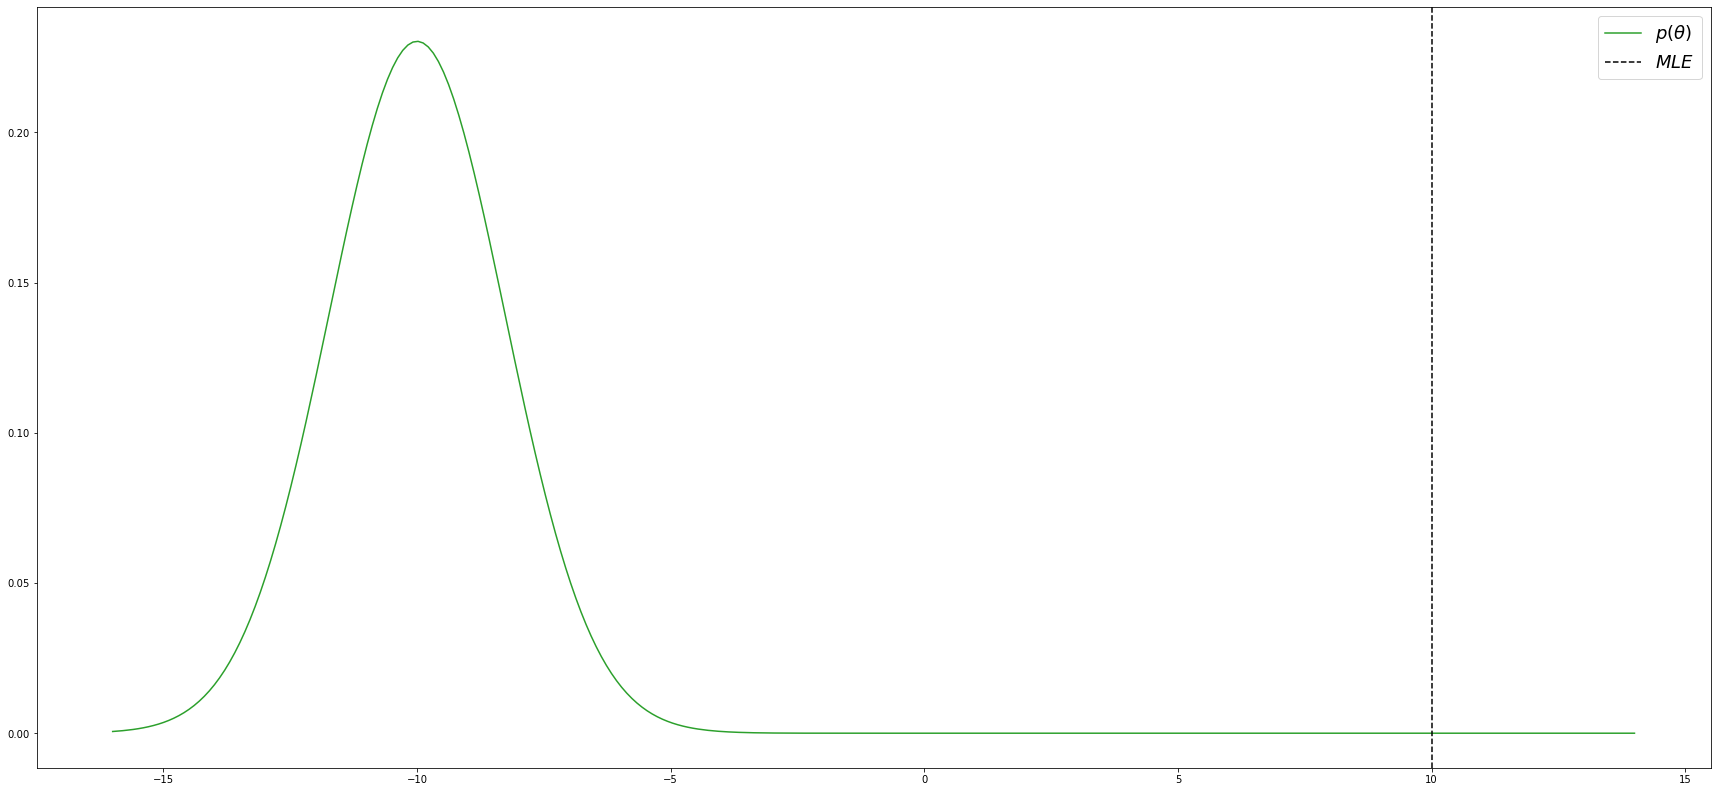

In [43]:
x_axis = np.linspace(-16, 14, 300)

fig, ax = plt.subplots(figsize=(30, 14))

ax.plot(x_axis, norm.pdf(x_axis, pmu, np.sqrt(pvar)), c='tab:green', label='$p(\\theta)$')
ax.axvline(theta, 0, 1, c='k', ls='--', label='$MLE$')

ax.legend(fontsize=18)

plt.show();

In [44]:
cmap = plt.get_cmap('coolwarm')

In [45]:
cmap(250)

(0.7350766252941177, 0.10445963105882351, 0.17149230125490195, 1.0)

In [46]:
def GVI_gauss(likelihood, D):
    
    mu = nn.Parameter(torch.tensor([0.]))
    log_var = nn.Parameter(torch.tensor(0.))
    
    optimizer = torch.optim.Adam([mu, log_var], lr=1e-3)
    for e in range(10000):
        nelbo = -likelihood(mu, log_var) + D(mu, log_var)
        
        nelbo.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return mu.detach().numpy(), torch.exp(log_var).detach().numpy()

In [47]:
X_torch = torch.tensor(X)
y_torch = torch.tensor(y)

def likelihood(mu, lvar):
    y_pred = (torch.randn_like(X_torch)*torch.exp(lvar/2) + mu)*X_torch
    return -0.5*torch.sum(np.log(2*np.pi) + (y_pred-y_torch)**2)

def D(mu, lvar, beta):
    return beta*factorized_gauss_KLD(mu, lvar, pmu, plog_var)

In [48]:
betas = [0.01, 0.1, 1., 3, 10.]
alphas = [0.4, 0.6, 0.8, 1.0][::-1]

qmus = {}
qvars = {}
for beta in betas:
    mu, var = GVI_gauss(likelihood, lambda x, y: D(x, y, beta))
    qmus[beta] = mu
    qvars[beta] = var

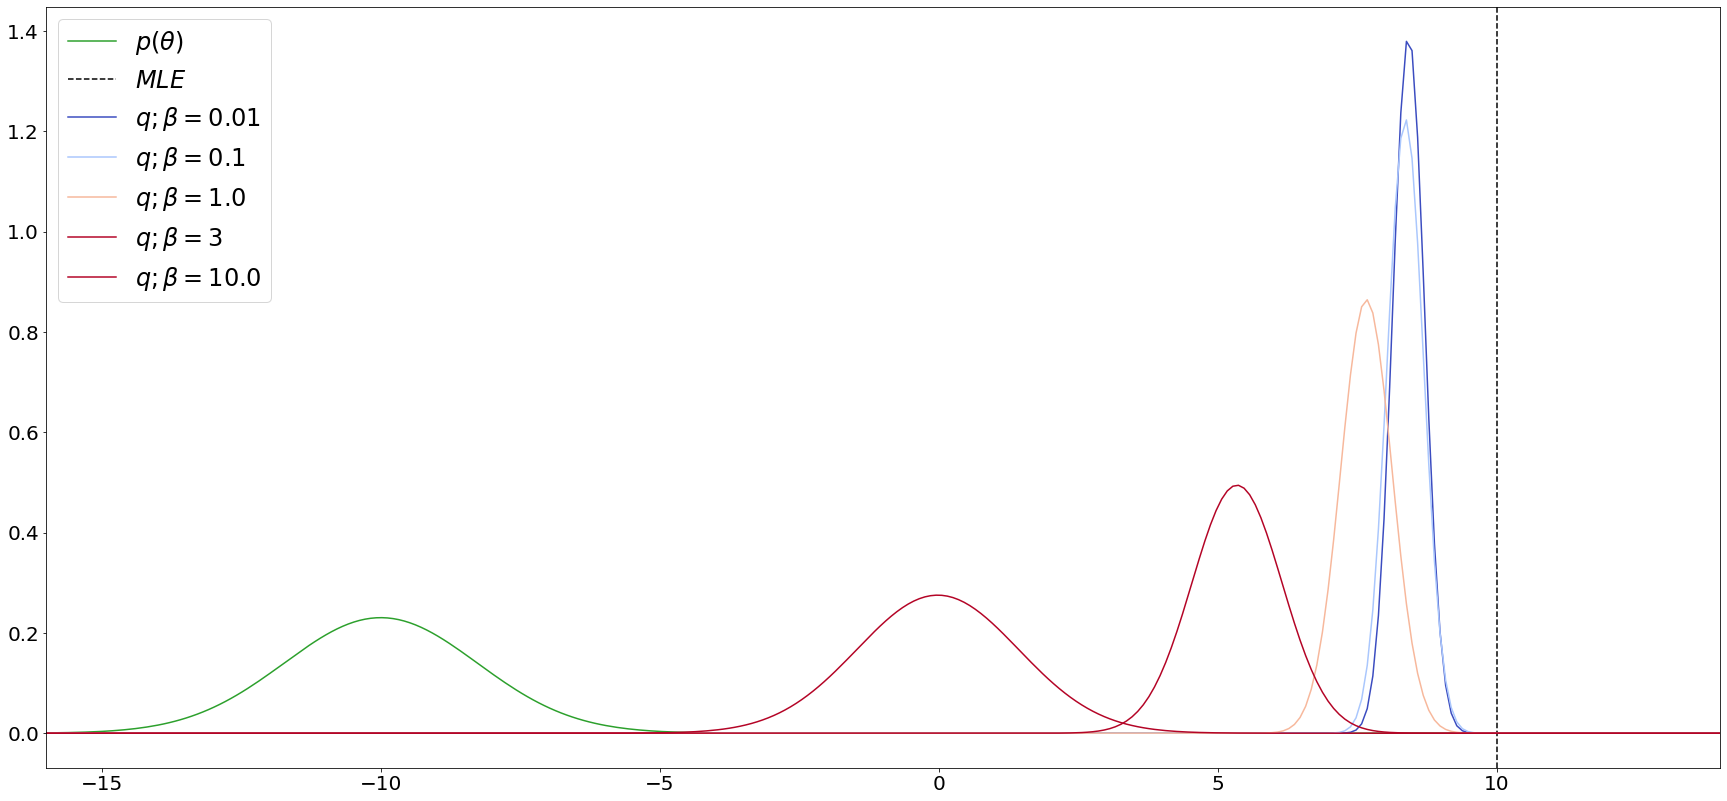

In [49]:
fig, ax = plt.subplots(figsize=(30, 14))

ax.plot(x_axis, norm.pdf(x_axis, pmu, np.sqrt(pvar)), c='tab:green', label='$p(\\theta)$')
ax.axvline(theta, 0, 1, c='k', ls='--', label='$MLE$')
for i, beta in enumerate(betas):
    ax.plot(x_axis, norm.pdf(x_axis, qmus[beta], qvars[beta]), c=cmap(i/3), label='$q; \\beta={}$'.format(beta))


ax.legend(fontsize=24, loc='upper left')
ax.tick_params(axis='both', labelsize=20)
ax.set_xlim(x_axis[0], x_axis[-1])

plt.show();

In [50]:
def Dar(mu, lvar, alpha=0.5, beta=1.0):
    return beta*factorized_gauss_ar(alpha, mu, lvar, pmu, plog_var)

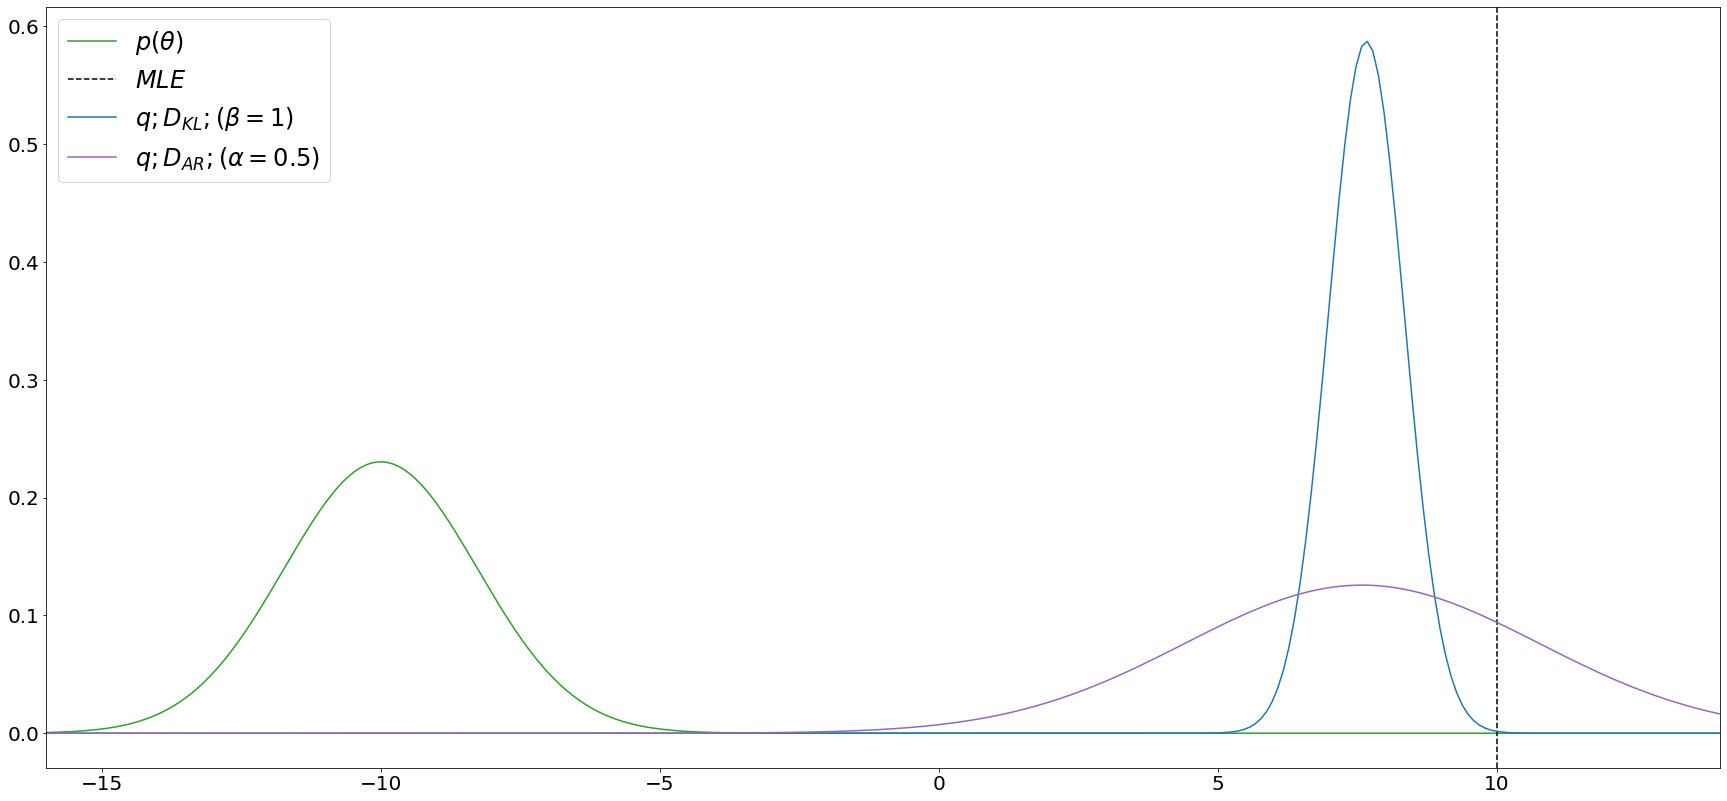

In [51]:
fig, ax = plt.subplots(figsize=(30, 14))

ax.plot(x_axis, norm.pdf(x_axis, pmu, np.sqrt(pvar)), c='tab:green', label='$p(\\theta)$')
ax.axvline(theta, 0, 1, c='k', ls='--', label='$MLE$')

## VI
ax.plot(x_axis, norm.pdf(x_axis, qmus[1], np.sqrt(qvars[1])), c='tab:blue', label='$q; D_{{KL}}; (\\beta=1)$'.format(1))

## GVI AR
mu, var = GVI_gauss(likelihood, lambda x, y: Dar(x, y, 0.5))
ax.plot(x_axis, norm.pdf(x_axis, mu, np.sqrt(var)), c='tab:purple', label='$q; D_{{AR}}; (\\alpha=0.5)$'.format(1))


ax.legend(fontsize=24)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlim(x_axis[0], x_axis[-1])

plt.show();